In [139]:
import pandas as pd
import numpy as np
import os
import plotly

import plotly.graph_objects as go
import numpy as np
import io
from PIL import Image
import ffmpeg

if os.getcwd().split(os.sep)[-1] == "notebooks":
    os.chdir("../")

# import helper functions coming with this project
import helper.plotly as py_help
import helper.event_data as ed_help
import helper.io as io_help
import helper.tracking_data as td_help
import helper.Visualizer as viz_help

# this is very useful as it makes sure that always all columns and rows of a data frame are displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [143]:
import importlib
importlib.reload(viz_help)

<module 'helper.Visualizer' from 'C:\\Clemens\\Learning\\soccer_analytics\\helper\\Visualizer.py'>

In [38]:
PATH = "C://Clemens//Learning//soccer_analytics//data//test"

In [216]:
game = 1
df_events, df_formations = io_help.read_metrica_event_data(game=game)
df_track = io_help.read_tracking_data(game=game, clean=True)
df_track = td_help.add_position_delta(df_track)
df_track["vx"] = df_track["dx"] / df_track["dt"]
df_track["vy"] = df_track["dy"] / df_track["dt"]

# Add heatmap to visualizer

In [40]:
# initialize the tracking data visualizer
viz = trackingDataVisualizer(df_track, df_events)
viz.set_sequence_by_frames(start_frame=300, end_frame=400)
viz.add_player_number()
fig = viz.get_figure()
# when watching a video we always need to call the figure like this, as validation is extremely slow for videos
plotly.offline.iplot(fig, validate=False, auto_play=False)

In [41]:
lst_vals = []
x = np.arange(106)
y = np.arange(69)
for i in np.arange(len(y)):
    lst_vals.append(list())
    for j in np.arange(len(x)):
        lst_vals[i].append(i+j)
        
z = np.array(lst_vals)

viz.add_heatmap([x]*101,[y]*101,[z]*101)
pic = viz.get_single_picture(383)
pic.show()

In [42]:
import time
start_time = time.time()
for frame in np.arange(301, 350):
    pic = viz.get_single_picture(frame) 
    fname = os.path.join(PATH, f"images//{frame}.png")
    pic.write_image(fname)
    #img_bytes = pic.to_image(format="png")
print("--- %s seconds ---" % (time.time() - start_time))

--- 31.98582100868225 seconds ---


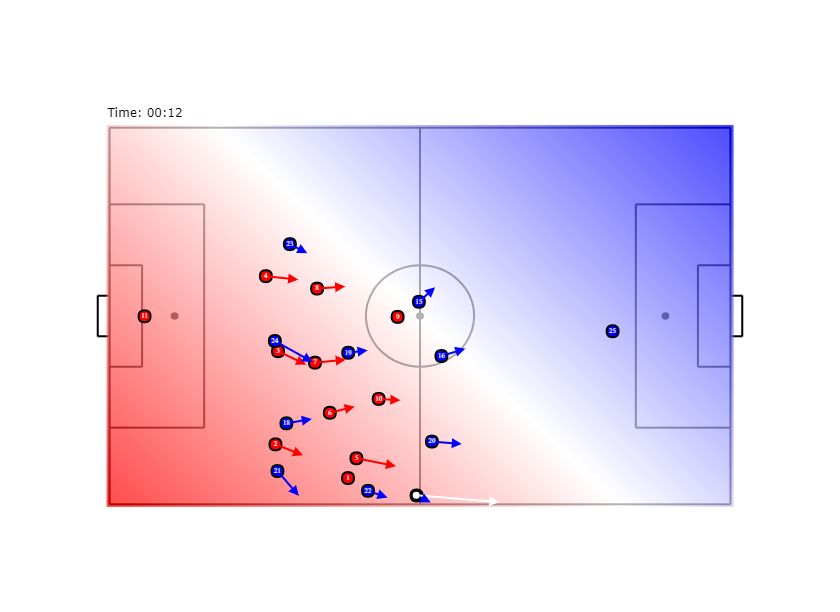

In [43]:
image = Image.open(io.BytesIO(img_bytes))
display(image)

In [33]:
ffmpeg.input(os.path.join(PATH, "images","*.png"), pattern_type="glob", framerate=25).output(os.path.join(PATH, "test.mp4")).run()

# Pitch control model

In [217]:
def default_model_params(time_to_control_veto=3):
    """
    default_model_params()
    
    Returns the default parameters that define and evaluate the model. See Spearman 2018 for more details.
    
    Parameters
    -----------
    time_to_control_veto: If the probability that another team or player can get to the ball and control it is less than 10^-time_to_control_veto, ignore that player.
    
    
    Returns
    -----------
    
    params: dictionary of parameters required to determine and calculate the model
    
    """
    # key parameters for the model, as described in Spearman 2018
    params = {}
    # model parameters
    params['max_player_accel'] = 7. # maximum player acceleration m/s/s, not used in this implementation
    params['max_player_speed'] = 5. # maximum player speed m/s
    params['reaction_time'] = 0.7 # seconds, time taken for player to react and change trajectory. Roughly determined as vmax/amax
    params['tti_sigma'] = 0.45 # Standard deviation of sigmoid function in Spearman 2018 ('s') that determines uncertainty in player arrival time
    params['kappa_def'] = 1.72  #1. # kappa parameter in Spearman 2018 (=1.72 in the paper) that gives the advantage defending players to control ball, I have set to 1 so that home & away players have same ball control probability
    params['lambda_att'] = 4.3 # ball control parameter for attacking team
    params['lambda_def'] = 4.3 * params['kappa_def'] # ball control parameter for defending team
    params['average_ball_speed'] = 30 #15. # average ball travel speed in m/s
    # numerical parameters for model evaluation
    params['int_dt'] = 0.04 # integration timestep (dt)
    params['max_int_time'] = 10 # upper limit on integral time
    params['model_converge_tol'] = 0.01 # assume convergence when PPCF>0.99 at a given location.
    # The following are 'short-cut' parameters. We do not need to calculated PPCF explicitly when a player has a sufficient head start. 
    # A sufficient head start is when the a player arrives at the target location at least 'time_to_control' seconds before the next player
    params['time_to_control_att'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_att'])
    params['time_to_control_def'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_def'])
    return params

In [219]:
params = default_model_params()

In [220]:
df_frame = df_track[(df_track["frame"] == 346)]

In [1023]:
class Player(object):
    """
    methods include:
    -----------
    simple_time_to_intercept(r_final): time take for player to get to target position (r_final) given current position
    probability_intercept_ball(T): probability player will have controlled ball at time T given their expected 
                                   time_to_intercept
    """

    # player object holds position, velocity, time-to-intercept and pitch control contributions for each player
    def __init__(self, row, params):
        self.id = row["playerId"]
        self.teamname = row["team"]
        self.playername = f"{row['team']}_{row['playerId']}"
        self.vmax = params['max_player_speed'] # player max speed in m/s. Could be individualised
        self.reaction_time = params['reaction_time'] # player reaction time in 's'. Could be individualised
        self.tti_sigma = params['tti_sigma'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.get_position(row)
        self.get_velocity(row)
        self.PPCF = 0. # initialise this for later
        self.PIP = 0. # pass interception probability
        self.t_int = None
    
    def get_position(self,row):
        self.position = np.array([row["xPos"],row["yPos"]])
        self.inframe = not np.any(np.isnan(self.position))
    
    def get_velocity(self,row):
        self.velocity = np.array([row["vx"], row["vy"]])
        if np.any( np.isnan(self.velocity) ):
            self.velocity = np.array([0.,0.])

    def simple_time_to_intercept(self, r_final):
        self.PPCF = 0. # initialise this for later
        # Time to intercept assumes that the player continues moving at current velocity for 'reaction_time' seconds
        # and then runs at full speed to the target position.
        r_reaction = self.position + self.velocity*self.reaction_time
        self.time_to_intercept = self.reaction_time + np.linalg.norm(r_final-r_reaction)/self.vmax
        return self.time_to_intercept

    def probability_intercept_ball(self,T):
        # probability of a player arriving at target location at time 'T' given their expected time_to_intercept (time of arrival), as described in Spearman 2018
        f = 1/(1. + np.exp( -np.pi/np.sqrt(3.0)/self.tti_sigma * (T-self.time_to_intercept) ) )
        return f

    def compute_center_and_radius(self, t):
        center = self.position + (1-math.exp(-alpha * t * 0.04)) / alpha * self.velocity
        radius = V_max * (t * 0.04 - (1-math.exp(-alpha * t * 0.04)) / alpha)
        return center, radius
    
    def interception_probability(self, t, ball_pos):
        
        center, radius = self.compute_center_and_radius(t)
        reach = np.linalg.norm(center - ball_pos) < radius
    
        if reach:
            if self.t_int is None:
                self.t_int = t

            P_int = 1/(1. + np.exp( -np.pi/np.sqrt(3.0)/sigma * (t-self.t_int) * 0.04))
        
        else :
            if self.t_int is not None:
                self.t_int = None
            P_int = 0
        
        return P_int
        

In [834]:
def get_team_players(df_frame, team):
    team_players = []
    for _, row in df_frame.iterrows():
        if row["team"] == team:
            team_players.append(Player(row, params))
    return team_players

In [223]:
defending_players = get_team_players(df_frame, "Home")
attacking_players = get_team_players(df_frame, "Away")
df_ball = df_frame[df_frame["playerId"] == -1].iloc[0]
ball_position = np.array([df_ball["xPos"], df_ball["yPos"]])
target_position = np.array([30, 34])

In [224]:
lst_vals = []
x = np.arange(106)
y = np.arange(69)
for y_pos in np.arange(len(y)):
    lst_vals.append(list())
    for x_pos in np.arange(len(x)):
        target_position = np.array([x_pos, y_pos])
        off_control = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, 
                                                        ball_position, params)
        lst_vals[y_pos].append(off_control[0])
        
z = np.array(lst_vals)

In [225]:
# initialize the tracking data visualizer
viz = viz_help.trackingDataVisualizer(df_track, df_events)
viz.set_sequence_by_frames(start_frame=300, end_frame=400)
viz.add_player_number()

In [1022]:
viz.add_heatmap([x]*101,[y]*101,[z]*101)
pic = viz.get_single_picture(346)
pic.show()

In [131]:
calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_position, params)

(1.0, 0.0)

In [115]:
len(attacking_players)

11

In [106]:
row_play = df_frame.iloc[0]

In [107]:
play = Player(row_play, params)

In [90]:
play.velocity

array([-0.105,  1.343])

In [93]:
play.simple_time_to_intercept([60, 40])

8.645957957699263

In [102]:
play.probability_intercept_ball(7)

0.0013127656585143178

In [71]:
play.vmax

5.0

In [64]:
row_play

frame              300
time                12
period               1
xPos           40.4155
yPos           4.53424
playerId             1
team              Home
xPosMetrica    40.4155
yPosMetrica    4.53424
ballInPlay           1
dx             -0.0042
dy             0.05372
dt                0.04
vx              -0.105
vy               1.343
Name: 6878, dtype: object

In [121]:
def generate_pitch_control_for_event(event_id, events, tracking_home, tracking_away, params, 
                                     field_dimen = (106.,68.,), n_grid_cells_x = 50):
    """ generate_pitch_control_for_event
    
    Evaluates pitch control surface over the entire field at the moment of the given event (determined by the index of the event passed as an input)
    
    Parameters
    -----------
        event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: tracking DataFrame for the Home team
        tracking_away: tracking DataFrame for the Away team
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        n_grid_cells_x: Number of pixels in the grid (in the x-direction) that covers the surface. Default is 50.
                        n_grid_cells_y will be calculated based on n_grid_cells_x and the field dimensions
        
    Returrns
    -----------
        PPCFa: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team.
               Surface for the defending team is just 1-PPCFa.
        xgrid: Positions of the pixels in the x-direction (field length)
        ygrid: Positions of the pixels in the y-direction (field width)
    """
    # get the details of the event (frame, team in possession, ball_start_position)
    pass_frame = events.loc[event_id]['Start Frame']
    pass_team = events.loc[event_id].Team
    ball_start_pos = np.array([events.loc[event_id]['Start X'],events.loc[event_id]['Start Y']])
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
    ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y )
    # initialise pitch control grids for attacking and defending teams 
    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
    if pass_team=='Home':
        attacking_players = initialise_players(tracking_home.loc[pass_frame],'Home',params)
        defending_players = initialise_players(tracking_away.loc[pass_frame],'Away',params)
    elif pass_team=='Away':
        defending_players = initialise_players(tracking_home.loc[pass_frame],'Home',params)
        attacking_players = initialise_players(tracking_away.loc[pass_frame],'Away',params)
    else:
        assert False, "Team in possession must be either home or away"
    # calculate pitch pitch control model at each location on the pitch
    for i in range( len(ygrid) ):
        for j in range( len(xgrid) ):
            target_position = np.array( [xgrid[j], ygrid[i]] )
            PPCFa[i,j],PPCFd[i,j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params)
    # check probabilitiy sums within convergence
    checksum = np.sum( PPCFa + PPCFd ) / float(n_grid_cells_y*n_grid_cells_x ) 
    assert 1-checksum < params['model_converge_tol'], "Checksum failed: %1.3f" % (1-checksum)
    return PPCFa,xgrid,ygrid


In [211]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 19 14:52:19 2020
Module for calculating a Pitch Control surface using MetricaSports's tracking & event data.
Pitch control (at a given location on the field) is the probability that a team will gain 
possession if the ball is moved to that location on the field. 
Methdology is described in "Off the ball scoring opportunities" by William Spearman:
http://www.sloansportsconference.com/wp-content/uploads/2018/02/2002.pdf
GitHub repo for this code can be found here:
https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking
Data can be found at: https://github.com/metrica-sports/sample-data
Functions
----------
calculate_pitch_control_at_target(): calculate the pitch control probability for the attacking and defending teams at a specified target position on the ball.
generate_pitch_control_for_event(): this function evaluates pitch control surface over the entire field at the moment
of the given event (determined by the index of the event passed as an input)
Classes
---------
The 'player' class collects and stores trajectory information for each player required by the pitch control calculations.
@author: Laurie Shaw (@EightyFivePoint)
"""

import numpy as np


def calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params):
    """ calculate_pitch_control_at_target
    
    Calculates the pitch control probability for the attacking and defending teams at a specified target position on the ball.
    
    Parameters
    -----------
        target_position: size 2 numpy array containing the (x,y) position of the position on the field to evaluate 
                         pitch control
        attacking_players: list of 'player' objects (see player class above) for the players on the attacking team (team in possession)
        defending_players: list of 'player' objects (see player class above) for the players on the defending team
        ball_start_pos: Current position of the ball (start position for a pass). If set to NaN, function will assume that 
                        the ball is already at the target position.
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        
    Returrns
    -----------
        PPCFatt: Pitch control probability for the attacking team
        PPCFdef: Pitch control probability for the defending team ( 1-PPCFatt-PPCFdef <  params['model_converge_tol'] )
    """
    # calculate ball travel time from start position to end position.
    if ball_start_pos is None or any(np.isnan(ball_start_pos)): # assume that ball is already at location
        ball_travel_time = 0.0 
    else:
        # ball travel time is distance to target position from current ball position divided assumed average ball speed
        ball_travel_time = np.linalg.norm( target_position - ball_start_pos )/params['average_ball_speed']
    
    # first get arrival time of 'nearest' attacking player (nearest also dependent on current velocity)
    tau_min_att = np.nanmin( [p.simple_time_to_intercept(target_position) for p in attacking_players] )
    tau_min_def = np.nanmin( [p.simple_time_to_intercept(target_position ) for p in defending_players] )
    
    # check whether we actually need to solve equation 3
    if tau_min_att-max(ball_travel_time,tau_min_def) >= params['time_to_control_def']:
        # if defending team can arrive significantly before attacking team, no need to solve pitch control model
        return 0., 1.
    elif tau_min_def-max(ball_travel_time,tau_min_att) >= params['time_to_control_att']:
        # if attacking team can arrive significantly before defending team, no need to solve pitch control model
        return 1., 0.
    else: 
        # solve pitch control model by integrating equation 3 in Spearman et al.
        # first remove any player that is far (in time) from the target location
        attacking_players = [p for p in attacking_players if p.time_to_intercept-tau_min_att < params['time_to_control_att']]
        defending_players = [p for p in defending_players if p.time_to_intercept-tau_min_def < params['time_to_control_def']]
        
        # set up integration arrays
        dT_array = np.arange(ball_travel_time-params['int_dt'],ball_travel_time+params['max_int_time'],params['int_dt']) 

        PPCFatt = np.zeros_like( dT_array )
        PPCFdef = np.zeros_like( dT_array )
        # integration equation 3 of Spearman 2018 until convergence or tolerance limit hit (see 'params')
        ptot = 0.0
        i = 1
        while 1-ptot>params['model_converge_tol'] and i<dT_array.size: 
            T = dT_array[i]
            for player in attacking_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * params['lambda_att']
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid attacking player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFatt[i] += player.PPCF # add to sum over players in the attacking team (remembering array element is zero at the start of each integration iteration)
            for player in defending_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * params['lambda_def']
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid defending player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFdef[i] += player.PPCF # add to sum over players in the defending team
            ptot = PPCFdef[i]+PPCFatt[i] # total pitch control probability 
            i += 1
        if i>=dT_array.size:
            print("Integration failed to converge: %1.3f" % (ptot) )
        return PPCFatt[i-1], PPCFdef[i-1]

# Sumpter

In [917]:
import math

In [918]:
def find_t_max(T, r0, v0, angle):
    
    tmp_r = copy.deepcopy(r0)
    tmp_v = copy.deepcopy(v0)

    for i in np.arange(T):

        if i  < 2/3 * T:
            tmp_a = factor * np.linalg.norm(tmp_v) * tmp_v
        else:
            tmp_a = -1 * mu * g * angle

        if any(np.abs(tmp_v) - np.abs(tmp_a * dt) < -1 * eps):
            return 1

        tmp_v = tmp_v + tmp_a * dt
        tmp_r = tmp_r + tmp_v * dt
    
    return -1

def get_t_max_for_different_speed(min_speed=1, max_speed=30):

    dict_t_max = {}
    for speed in np.arange(min_speed, max_speed + 1):

        r0 = np.array([0., 0.])
        angle = np.array([1, 0])
        v0 = speed * angle

        min_val = 0
        max_val = 300
        mid_val = int((max_val + min_val) / 2)

        while True:
            tmp_val = find_t_max(mid_val, r0, v0, angle)
            if tmp_val == 1:
                max_val = mid_val
                mid_val = int((max_val + min_val) / 2)
            elif tmp_val == -1:
                min_val = mid_val
                mid_val = int((max_val + min_val) / 2)    

            if min_val == mid_val:
                break

        dict_t_max[speed] = mid_val
        
    return dict_t_max

In [919]:
def compute_ball_position_at_every_time(r0, v0, t_max):
    tmp_r = copy.deepcopy(r0)
    tmp_v = copy.deepcopy(v0)
    
    factor = -1/m * rho * drag * area

    r = [tmp_r]
    v = [tmp_v]
    a = []

    for i in np.arange(t_max):

        if i  < 2/3 * t_max:
            tmp_a = factor * np.linalg.norm(tmp_v) * tmp_v
        else:
            tmp_a = -1 * mu * g * angle

        tmp_v = tmp_v + tmp_a * dt
        tmp_r = tmp_r + tmp_v * dt

        r.append(tmp_r)
    
    return r

In [920]:
dict_t_max = get_t_max_for_different_speed()

In [1052]:
# player params
V_max = 7.8
alpha = 1.3
lambda_player = 4.3
sigma = 0.45

# ball params
m = 0.42
rho = 1.225
drag = 0.25
area = 0.038
dt = 0.04
mu = 0.55
g = 9.81

In [1102]:
speed = 12
angle = np.array([-1.05, 1])

In [1103]:
# compute ball positions at the different times
angle = angle / np.linalg.norm(angle)
v0 = speed * angle
r = compute_ball_position_at_every_time(ball_position, v0, dict_t_max[speed])

In [1104]:
defending_players = get_team_players(df_frame, "Home")
attacking_players = get_team_players(df_frame, "Away")
df_ball = df_frame[df_frame["playerId"] == -1].iloc[0]
ball_position = np.array([df_ball["xPos"], df_ball["yPos"]])

t_int = None
player_prob = 0
pass_prob_att = np.zeros(250)
pass_prob_def = np.zeros(250)

ball_in_play = True
total_proba = 0

t = 1

while 1 - total_proba > 0.01 and ball_in_play:

    if t >= len(r):
        ball_pos = r[-1]
    else:
        ball_pos = r[t]
    
    for player in attacking_players:
    
        P_int = player.interception_probability(t, ball_pos)
        dPdT = (1-pass_prob_att[i-1]) * P_int * lambda_player
 
        player.PIP += dPdT * dt        
        pass_prob_att[t] += player.PIP
    
    for player in defending_players:
        
        P_int = player.interception_probability(t, ball_pos)
        dPdT = (1-pass_prob_att[i-1]) * P_int * lambda_player
 
        player.PIP += dPdT * dt        
        pass_prob_def[t] += player.PIP

    if (ball_pos[0] > 105) or (ball_pos[0] < 0) or (ball_pos[1] > 68) or (ball_pos[1] < 0):
        ball_in_play = False
    
    total_proba = pass_prob_att[t] + pass_prob_def[t]
    
    t += 1    

if t-1 >= len(r):
    print(r[-1])
else:
    print(r[t-1])
print(pass_prob_def[t-1])
print(pass_prob_att[t-1])

[41.50610535 13.57101586]
1.00623284046193
0.0


In [1072]:
t

28

In [1077]:
pass_prob_def[t-1]

0.49787459396305755

In [1078]:
pass_prob_att[t-1]

0.6167755914802021

In [1020]:
r

[array([53.45445,  2.19164]),
 array([52.29435,  2.19164]),
 array([51.17154076,  2.19164   ]),
 array([50.08366344,  2.19164   ]),
 array([49.02857829,  2.19164   ]),
 array([48.00433818,  2.19164   ]),
 array([47.009166,  2.19164 ]),
 array([46.04143526,  2.19164   ]),
 array([45.09965344,  2.19164   ]),
 array([44.18244762,  2.19164   ]),
 array([43.28855189,  2.19164   ]),
 array([42.41679649,  2.19164   ]),
 array([41.56609824,  2.19164   ]),
 array([40.73545218,  2.19164   ]),
 array([39.9239241,  2.19164  ]),
 array([39.13064413,  2.19164   ]),
 array([38.35480081,  2.19164   ]),
 array([37.59563606,  2.19164   ]),
 array([36.85244047,  2.19164   ]),
 array([36.1245493,  2.19164  ]),
 array([35.41133872,  2.19164   ]),
 array([34.71222251,  2.19164   ]),
 array([34.02664912,  2.19164   ]),
 array([33.35409895,  2.19164   ]),
 array([32.69408192,  2.19164   ]),
 array([32.04613526,  2.19164   ]),
 array([31.40982153,  2.19164   ]),
 array([30.78472676,  2.19164   ]),
 array([30.1

In [1075]:
for player in defending_players:
    print(player.playername)
    print(player.PIP)

Home_1
0.49787459396305755
Home_2
0.0
Home_3
0.0
Home_4
0.0
Home_5
0.0
Home_6
0.0
Home_7
0.0
Home_8
0.0
Home_9
0.0
Home_10
0.0
Home_11
0.0


In [1025]:
player = attacking_players[0]

In [1028]:
player.position

array([55.0578 , 40.12612])

In [1038]:
player.compute_center_and_radius(10)

(array([55.47536586, 40.78362053]), 0.6871232878211663)

In [863]:
pass_prob_att[:t-1]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.086, 0.172,
       0.258, 0.344, 0.43 , 0.516, 0.602, 0.688, 0.774, 0.86 , 0.946])

In [767]:
t_int

21

In [776]:
T = 5

P_int = 1/(1. + np.exp( -np.pi/np.sqrt(3.0)/sigma * (T-t_int) * 0.04) )

In [775]:
f

0.012119332967593866

In [707]:
r0 = np.array([0., 0.])
speed = 10
angle = np.array([1., 0.])
angle = angle / np.linalg.norm(angle)
v0 = speed * angle

In [708]:
m = 0.42
rho = 1.225
drag = 0.25
area = 0.038
dt = 0.04
mu = 0.55
g = 9.81

In [709]:
dict_t_max = get_t_max_for_different_speed()

In [710]:
def compute_ball_position_at_every_time(r0, v0, t_max):
    tmp_r = copy.deepcopy(r0)
    tmp_v = copy.deepcopy(v0)
    
    factor = -1/m * rho * drag * area

    r = [tmp_r]
    v = [tmp_v]
    a = []

    for i in np.arange(t_max):

        if i  < 2/3 * t_max:
            tmp_a = factor * np.linalg.norm(tmp_v) * tmp_v
        else:
            tmp_a = -1 * mu * g * angle

        tmp_v = tmp_v + tmp_a * dt
        tmp_r = tmp_r + tmp_v * dt

        #a_1.append(tmp_a)
        #v_1.append(tmp_v)
        r.append(tmp_r)
    
    return r

In [711]:
r = compute_ball_position_at_every_time(r0, v0, dict_t_max[speed])
df_pos = pd.DataFrame(r, columns=["xPosBall", "yPosBall"])
df_pos["frame"] = np.arange(len(df_pos))

In [712]:
df_pos.head()

,xPosBall,yPosBall,frame
0,0.000000,0.0,0
1,0.395567,0.0,1
2,0.786798,0.0,2
3,1.173788,0.0,3
4,1.556628,0.0,4


In [668]:
def find_t_max(T, r0, v0):
    
    tmp_r = copy.deepcopy(r0)
    tmp_v = copy.deepcopy(v0)

    for i in np.arange(T):

        if i  < 2/3 * T:
            tmp_a = factor * np.linalg.norm(tmp_v) * tmp_v
        else:
            tmp_a = -1 * mu * g * angle

        if any(np.abs(tmp_v) - np.abs(tmp_a * dt) < -1 * eps):
            return 1

        tmp_v = tmp_v + tmp_a * dt
        tmp_r = tmp_r + tmp_v * dt
    
    return -1

def get_t_max_for_different_speed(min_speed=1, max_speed=30):

    dict_t_max = {}
    for speed in np.arange(min_speed, max_speed + 1):

        r0 = np.array([0., 0.])
        v0 = np.array([speed, 0])

        min_val = 0
        max_val = 300
        mid_val = int((max_val + min_val) / 2)

        while True:
            tmp_val = find_t_max(mid_val, r0, v0)
            if tmp_val == 1:
                max_val = mid_val
                mid_val = int((max_val + min_val) / 2)
            elif tmp_val == -1:
                min_val = mid_val
                mid_val = int((max_val + min_val) / 2)    

            if min_val == mid_val:
                break

        dict_t_max[speed] = mid_val
        
    return dict_t_max

In [661]:
mid_val

86

In [604]:
min_val

14

In [587]:
sers

1

In [536]:
tmp_r = copy.deepcopy(r0)
tmp_v = copy.deepcopy(v0)

r_2 = [tmp_r]
v_2 = [tmp_v]
a_2 = []

In [537]:
eps = 0.00001
for i in np.arange(150):
    tmp_a = -1 * mu * g * angle
    
    if any(np.abs(tmp_v) - np.abs(tmp_a * dt) < -1 * eps):
        break
    
    tmp_v = tmp_v +  tmp_a * dt
    tmp_r = tmp_r + tmp_v * dt
    
    a_2.append(tmp_a)
    v_2.append(tmp_v)
    r_2.append(tmp_r)

In [538]:
r_2

[array([0., 0.]),
 array([0.3913672, 0.       ]),
 array([0.7741016, 0.       ]),
 array([1.1482032, 0.       ]),
 array([1.513672, 0.      ]),
 array([1.870508, 0.      ]),
 array([2.2187112, 0.       ]),
 array([2.5582816, 0.       ]),
 array([2.8892192, 0.       ]),
 array([3.211524, 0.      ]),
 array([3.525196, 0.      ]),
 array([3.8302352, 0.       ]),
 array([4.1266416, 0.       ]),
 array([4.4144152, 0.       ]),
 array([4.693556, 0.      ]),
 array([4.964064, 0.      ]),
 array([5.2259392, 0.       ]),
 array([5.4791816, 0.       ]),
 array([5.7237912, 0.       ]),
 array([5.959768, 0.      ]),
 array([6.187112, 0.      ]),
 array([6.4058232, 0.       ]),
 array([6.6159016, 0.       ]),
 array([6.8173472, 0.       ]),
 array([7.01016, 0.     ]),
 array([7.19434, 0.     ]),
 array([7.3698872, 0.       ]),
 array([7.5368016, 0.       ]),
 array([7.6950832, 0.       ]),
 array([7.844732, 0.      ]),
 array([7.985748, 0.      ]),
 array([8.1181312, 0.       ]),
 array([8.2418816,

In [539]:
r_1

[array([0., 0.]),
 array([0.39556667, 0.        ]),
 array([0.78674914, 0.        ]),
 array([1.173596, 0.      ]),
 array([1.55615531, 0.        ]),
 array([1.93447459, 0.        ]),
 array([2.30860083, 0.        ]),
 array([2.6785805, 0.       ]),
 array([3.04445957, 0.        ]),
 array([3.40628348, 0.        ]),
 array([3.76409717, 0.        ]),
 array([4.11794509, 0.        ]),
 array([4.4678712, 0.       ]),
 array([4.81391896, 0.        ]),
 array([5.15613136, 0.        ]),
 array([5.4945509, 0.       ]),
 array([5.82921963, 0.        ]),
 array([6.16017911, 0.        ]),
 array([6.48747046, 0.        ]),
 array([6.81113433, 0.        ]),
 array([7.13121092, 0.        ]),
 array([7.44774, 0.     ]),
 array([7.76076088, 0.        ]),
 array([8.07031245, 0.        ]),
 array([8.37643316, 0.        ]),
 array([8.67916102, 0.        ]),
 array([8.97853365, 0.        ]),
 array([9.27458824, 0.        ]),
 array([9.56736155, 0.        ]),
 array([9.85688996, 0.        ]),
 array([10.1

In [518]:
np.abs(tmp_v) - np.abs(tmp_a * dt) < -1 * eps

array([ True, False])

In [ ]:
np.abs(tmp_v)

In [493]:
a_2

[array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.    ]),
 array([-5.3955, -0.

In [492]:
v_2

[array([20.,  0.]),
 array([19.56836,  0.     ]),
 array([19.35254,  0.     ]),
 array([19.13672,  0.     ]),
 array([18.9209,  0.    ]),
 array([18.70508,  0.     ]),
 array([18.48926,  0.     ]),
 array([18.27344,  0.     ]),
 array([18.05762,  0.     ]),
 array([17.8418,  0.    ]),
 array([17.62598,  0.     ]),
 array([17.41016,  0.     ]),
 array([17.19434,  0.     ]),
 array([16.97852,  0.     ]),
 array([16.7627,  0.    ]),
 array([16.54688,  0.     ]),
 array([16.33106,  0.     ]),
 array([16.11524,  0.     ]),
 array([15.89942,  0.     ]),
 array([15.6836,  0.    ]),
 array([15.46778,  0.     ]),
 array([15.25196,  0.     ]),
 array([15.03614,  0.     ]),
 array([14.82032,  0.     ]),
 array([14.6045,  0.    ]),
 array([14.38868,  0.     ]),
 array([14.17286,  0.     ]),
 array([13.95704,  0.     ]),
 array([13.74122,  0.     ]),
 array([13.5254,  0.    ]),
 array([13.30958,  0.     ]),
 array([13.09376,  0.     ]),
 array([12.87794,  0.     ]),
 array([12.66212,  0.     ]),
 a

In [488]:
r_2

[array([0., 0.]),
 array([0.7913672, 0.       ]),
 array([1.5741016, 0.       ]),
 array([2.3482032, 0.       ]),
 array([3.113672, 0.      ]),
 array([3.870508, 0.      ]),
 array([4.6187112, 0.       ]),
 array([5.3582816, 0.       ]),
 array([6.0892192, 0.       ]),
 array([6.811524, 0.      ]),
 array([7.525196, 0.      ]),
 array([8.2302352, 0.       ]),
 array([8.9266416, 0.       ]),
 array([9.6144152, 0.       ]),
 array([10.293556,  0.      ]),
 array([10.964064,  0.      ]),
 array([11.6259392,  0.       ]),
 array([12.2791816,  0.       ]),
 array([12.9237912,  0.       ]),
 array([13.559768,  0.      ]),
 array([14.187112,  0.      ]),
 array([14.8058232,  0.       ]),
 array([15.4159016,  0.       ]),
 array([16.0173472,  0.       ]),
 array([16.61016,  0.     ]),
 array([17.19434,  0.     ]),
 array([17.7698872,  0.       ]),
 array([18.3368016,  0.       ]),
 array([18.8950832,  0.       ]),
 array([19.444732,  0.      ]),
 array([19.985748,  0.      ]),
 array([20.51813